### Binary classification based on 3 layers neural network
#### author: Kim Jeong Min

##### load images

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torch.autograd import Variable
from random import shuffle

import math

In [0]:
class Linear(nn.Module):

    def __init__(self, num_classes=2, p=0.0):

        super(Linear, self).__init__()

        self.ms = list()
        
        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 512
        _num2           = 128
        _num3           = 64
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, _num3, bias=True)
        self.fc4        = nn.Linear(_num3, num_classes, bias=True)
        self.ms.append(self.fc1)
        self.ms.append(self.fc2)
        self.ms.append(self.fc3)
        self.ms.append(self.fc4)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU())
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU())
        self.fc_layer3  = nn.Sequential(self.fc3, nn.ReLU())
        self.fc_layer4  = nn.Sequential(self.fc4, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3, self.fc_layer4)
        
        self._initialize_weight()
        
        self.p = p
        self.dropout = nn.Dropout(p=self.p)
        
    def _initialize_weight(self):

        for m in self.ms:
            
            n = m.in_features
            m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        #x = F.softmax(self.fc4(x),dim=1)
        
        return x


In [0]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
drive_prefix = 'drive/My Drive/'
train_data_path = drive_prefix + 'horse-or-human/train'
trains_set = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
loader_train = torch.utils.data.DataLoader(trains_set, batch_size=64, shuffle=False, num_workers=1)  


test_data_path = drive_prefix + 'horse-or-human/validation'
test_set = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
loader_test = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=1)  

num_classes = 2

##### load neural network model

In [0]:
model = Linear(num_classes=num_classes, p=0.5)

##### Set the flag for using cuda

In [0]:
bCuda = True
if bCuda:
    model.cuda()

##### optimization algorithm

In [0]:
LR = 0.02
optimizer   = optim.SGD(model.parameters(), lr=LR, weight_decay=1e-3 * 5)
objective   = nn.CrossEntropyLoss()

##### function for training the model

In [0]:
def train():
    # print('train the model at given epoch')
    loss_train          = []
    acc_train           = []
    model.train()
    for idx_batch, (data, target) in enumerate(loader_train):
        if bCuda:
            data, target    = data.cuda(), target.cuda()
            
        data, target    = Variable(data), Variable(target)
        optimizer.zero_grad()
        
        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
        pred        = output.data.max(1)[1]
        correct     = pred.eq(target.data.view_as(pred)).cpu().sum()
        acc_train_batch   = 100. * float(correct) / len(data)
        acc_train.append(acc_train_batch)
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    acc_train_mean      = np.mean(acc_train)
    acc_train_std       = np.std(acc_train)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'acc_train_mean': acc_train_mean, 'acc_train_std': acc_train_std}

##### function for testing the model

In [0]:
def test():
    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

##### iteration for the epoch

In [9]:
epoch = 1000
loss_train_mean = list()
loss_train_std = list()
acc_train_mean = list()
acc_train_std = list()
loss_test = list()
accuracy_test = list()

for e in range(epoch):
        
    result_train    = train()
    result_test     = test()
    
    result_loss_train_mean = result_train['loss_train_mean']
    result_loss_train_std =  result_train['loss_train_std']
    result_acc_train_mean =  result_train['acc_train_mean']
    result_acc_train_std =  result_train['acc_train_std']
    result_loss_test =       result_test['loss_test']
    result_accuracy_test =   result_test['accuracy_test']

    loss_train_mean.append( result_loss_train_mean)
    loss_train_std.append(  result_loss_train_std)
    acc_train_mean.append(  result_acc_train_mean)
    acc_train_std.append(  result_acc_train_std)
    loss_test.append(       result_loss_test)
    accuracy_test.append(   result_accuracy_test)
    
    epoch_str = '[epoch '+ '{:05d}'.format(e)+ ']  '
    epoch_str += 'loss: '+ '(training)' + str(round(result_loss_train_mean, 5))+ ' (testing) ' + str(round(result_loss_test, 5)) + ', '
    epoch_str += 'accuracy: '+ '(training)' + str(round(result_acc_train_mean, 5))+ ' (testing) ' + str(round(result_accuracy_test, 5))
    print(epoch_str)
    
    if e > epoch - 100 and accuracy_test[-1] > accuracy_test[-2] and accuracy_test[-1] > accuracy_test[-3]:
        break;
    
    #adaptive learning rate
    for g in optimizer.param_groups:
        g['lr'] = g['lr'] * 0.9989

[epoch 00000]  loss: (training)0.01333 (testing) 0.01083, accuracy: (training)56.43382 (testing) 50.0
[epoch 00001]  loss: (training)0.01331 (testing) 0.01081, accuracy: (training)54.77941 (testing) 50.0
[epoch 00002]  loss: (training)0.01328 (testing) 0.01081, accuracy: (training)52.20588 (testing) 50.0
[epoch 00003]  loss: (training)0.01326 (testing) 0.01081, accuracy: (training)51.65441 (testing) 50.0
[epoch 00004]  loss: (training)0.01324 (testing) 0.0108, accuracy: (training)51.37868 (testing) 50.0
[epoch 00005]  loss: (training)0.01322 (testing) 0.0108, accuracy: (training)51.93015 (testing) 50.0
[epoch 00006]  loss: (training)0.01319 (testing) 0.0108, accuracy: (training)54.96324 (testing) 50.0
[epoch 00007]  loss: (training)0.01317 (testing) 0.0108, accuracy: (training)55.33088 (testing) 50.0
[epoch 00008]  loss: (training)0.01315 (testing) 0.0108, accuracy: (training)55.88235 (testing) 50.0
[epoch 00009]  loss: (training)0.01313 (testing) 0.01081, accuracy: (training)55.33088 

##### plot result

In [0]:
def print_history_graph(loss_history, loss_train_std, acc_history, acc_train_std, vloss_history, vacc_history):
    #plt.plot(acc_history, color='#ff0000', label='Train Accuracy')
    plt.errorbar(list(range(len(acc_history))), acc_history, yerr=acc_train_std, ecolor = '#ffcccc', color='#ff0000', label='Train Accuracy')
    plt.plot(vacc_history, color='#0000ff', label='Validation Accuracy')
    plt.legend(['Validation Accuracy', 'Train Accuracy'])
    plt.title('Accuracy')
    plt.show()

    #plt.plot(loss_history, color='#ff0000', label='Train Loss')
    plt.errorbar(list(range(len(loss_history))), loss_history, yerr=loss_train_std, ecolor = '#ffcccc', color='#ff0000', label='Train Loss')
    plt.plot(vloss_history, color='#0000ff', label='Validation Loss')
    plt.legend(['Validation Loss','Train Loss'])
    plt.title('Loss')
    plt.show()
    
    nx, ny = 3, 3
    data = (('dataset', 'loss', 'accuracy'), ('train', str(np.round(loss_history[-1],4)), str(np.round(acc_history[-1],4))), ('validation', str(np.round(vloss_history[-1],4)), str(np.round(vacc_history[-1],4))))
    pl.figure()
    tb = pl.table(cellText=data, loc=(0,0), cellLoc='center')

    tc = tb.properties()['child_artists']
    for cell in tc: 
        cell.set_height(1/ny)
        cell.set_width(1/nx)

    ax = pl.gca()
    ax.set_xticks([])
    ax.set_yticks([])

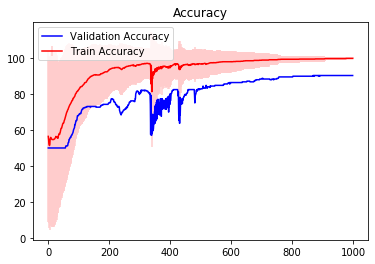

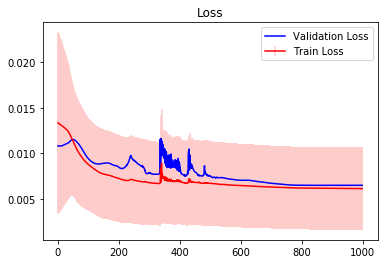

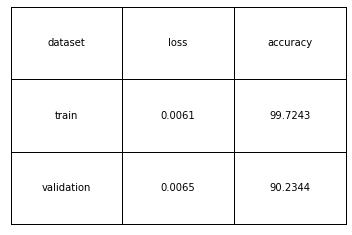

In [13]:
print_history_graph(loss_train_mean, loss_train_std, acc_train_mean, acc_train_std, loss_test, accuracy_test)